#  Synthetic Feasibility

当运行大规模枚举时，合成可行性是一个问题。通常，被列举的分子很难制造，因此不值得检验，即使它们的其他化学性质在计算机模拟中很好。本教程将介绍如何训练[ScScore](https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622)模型[1]。

该模型的思想是在一对分子上进行训练，其中一个分子比另一个分子“更复杂”。然后神经网络就可以做出分数，试图保持分子的这种成对排序。最终的结果是一个可以给出分子相对复杂性的模型。

这篇论文对reaxys中的每一个反应进行了训练，宣称产物比反应物更复杂。由于这个训练集非常昂贵，我们将对任意分子进行训练，如果一个分子的SMILES字符串较长，则该分子声明为更复杂的分子。在现实世界中，你可以使用任何对项目有意义的复杂性度量。


在本教程中，我们将使用 Tox21 数据集来训练我们简单的合成可行性模型。

## Colab

This tutorial and the rest in this sequence can be done in Google colab. If you'd like to open this notebook in colab, you can use the following link.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/deepchem/deepchem/blob/master/examples/tutorials/Synthetic_Feasibility_Scoring.ipynb)



In [ ]:
!pip install --pre deepchem
import deepchem
deepchem.__version__

# 创建数据集

让我们从加载一些分子开始。我们加载 Tox21，指定 `splitter=None`，这样所有内容都将作为单个数据集返回。

In [1]:
import deepchem as dc
tasks, datasets, transformers = dc.molnet.load_tox21(featurizer='Raw', splitter=None)
molecules = datasets[0].X

因为 ScScore 是根据相对复杂度进行训练的，所以我们希望数据集中的 `X` 张量具有3个维度 `(sample_id, molecule_id, features)` 。 `molecule_id` 维度的大小为2，因为一个样本是一对分子。如果第一个分子比第二个分子更复杂，则标记为1。下面我们介绍的函数 `create_dataset` 从给定的列表中随机提取微笑字符串对，并根据这种复杂性度量对它们进行排序。

在现实世界中，你可以使用购买成本或所需反应步骤数作为复杂度评分。

In [2]:
from rdkit import Chem
import random
from deepchem.feat import CircularFingerprint
import numpy as np


def create_dataset(fingerprints, smiles_lens, ds_size=100000):
    """
    m1: list of np.Array
        fingerprints for molecules
    m2: list of int
        length of a molecules SMILES string
    
    returns:
        dc.data.Dataset for input into ScScore Model
        
    Dataset.X
        shape is (sample_id, molecule_id, features)
    Dataset.y
        shape is (sample_id,)
        values is 1 if the 0th index molecule is more complex
                  0 if the 1st index molecule is more complex
    """
    X, y = [], []
    all_data = list(zip(fingerprints, smiles_lens))
    while len(y) < ds_size:
        i1 = random.randrange(0, len(smiles_lens))
        i2 = random.randrange(0, len(smiles_lens))
        m1 = all_data[i1]
        m2 = all_data[i2]
        if m1[1] == m2[1]:
            continue
        if m1[1] > m2[1]:
            y.append(1.0)
        else:
            y.append(0.0)
        X.append([m1[0], m2[0]])
    return dc.data.NumpyDataset(np.array(X), np.expand_dims(np.array(y), axis=1))

复杂性排序器就位后，我们现在可以构建数据集了。让我们从随机地将分子列表分成训练集和测试集开始。

In [3]:
molecule_ds = dc.data.NumpyDataset(np.array(molecules))
splitter = dc.splits.RandomSplitter()
train_mols, test_mols = splitter.train_test_split(molecule_ds)

我们将用具有手性的 ECFP 指纹（与源论文匹配）对所有分子进行特征化，然后使用上面定义的函数构建我们的成对数据集。

In [4]:
n_features = 1024
featurizer = dc.feat.CircularFingerprint(size=n_features, radius=2, chiral=True)
train_features = featurizer.featurize(train_mols.X)
train_smiles_len = [len(Chem.MolToSmiles(x)) for x in train_mols.X]
train_dataset = create_dataset(train_features, train_smiles_len)

现在我们已经创建了数据集，让我们在这个数据集上训练一个 `ScScoreModel`。

In [5]:
model = dc.models.ScScoreModel(n_features=n_features)
model.fit(train_dataset, nb_epoch=20)

0.03494557857513428

# 模型性能

让我们来评估一下这个模型在我们的抵制分子上的表现。SaScores 应该从从未见过的分子追踪 SMILES 字符串的长度。

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
mol_scores = model.predict_mols(test_mols.X)
smiles_lengths = [len(Chem.MolToSmiles(x)) for x in test_mols.X]

现在使用 matplotlib 绘制分子 smiles 字符串的长度与 SaScore 的比较。

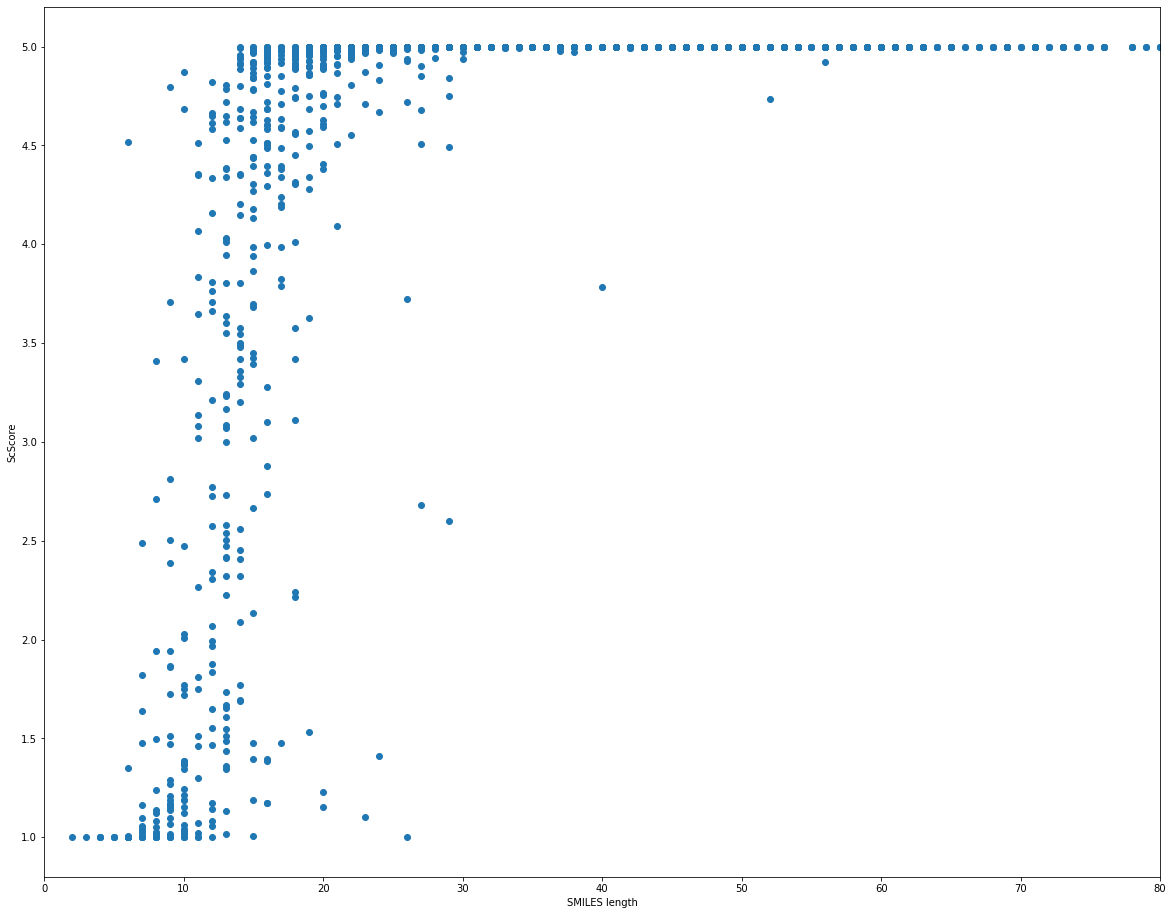

In [8]:
plt.figure(figsize=(20,16))
plt.scatter(smiles_lengths, mol_scores)
plt.xlim(0,80)
plt.xlabel("SMILES length")
plt.ylabel("ScScore")
plt.show()

正如我们所看到的，模型通常跟踪 SMILES 的长度。它在8到30个字符之间有很好的丰富，并且大大小小的 SMILES 字符串都非常准确。

现在你可以用比 SMILES 长度更有意义的度量来训练你自己的模型了！

# Congratulations! Time to join the Community!

Congratulations on completing this tutorial notebook! If you enjoyed working through the tutorial, and want to continue working with DeepChem, we encourage you to finish the rest of the tutorials in this series. You can also help the DeepChem community in the following ways:

## Star DeepChem on [GitHub](https://github.com/deepchem/deepchem)
This helps build awareness of the DeepChem project and the tools for open source drug discovery that we're trying to build.

## Join the DeepChem Gitter
The DeepChem [Gitter](https://gitter.im/deepchem/Lobby) hosts a number of scientists, developers, and enthusiasts interested in deep learning for the life sciences. Join the conversation!


# 参考文献：

[1] https://pubs.acs.org/doi/abs/10.1021/acs.jcim.7b00622